<a href="https://www.kaggle.com/code/kgxiao/american-sign-pytorch?scriptVersionId=106348527" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.functional as F
import torchmetrics
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# VIEW DATA

train = pd.read_csv('../input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv')
test = pd.read_csv('../input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv')

In [3]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [4]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [5]:
print('nunique values:',train['label'].nunique())
train['label'].unique()

nunique values: 24


array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

In [6]:
#drop
y_train = train['label']
train.drop(columns='label', axis=1, inplace=True)

y_test = test['label']
test.drop(columns='label', axis=1, inplace=True)

# div 255.0 
train.loc[:] = train.loc[:].values / 255.0
test.loc[:] = test.loc[:].values / 255.0

In [7]:
# size = 1 * 784 -> 28*28
train_view = train.copy()
train_view = train_view.values.reshape(-1, 28, 28, 1)

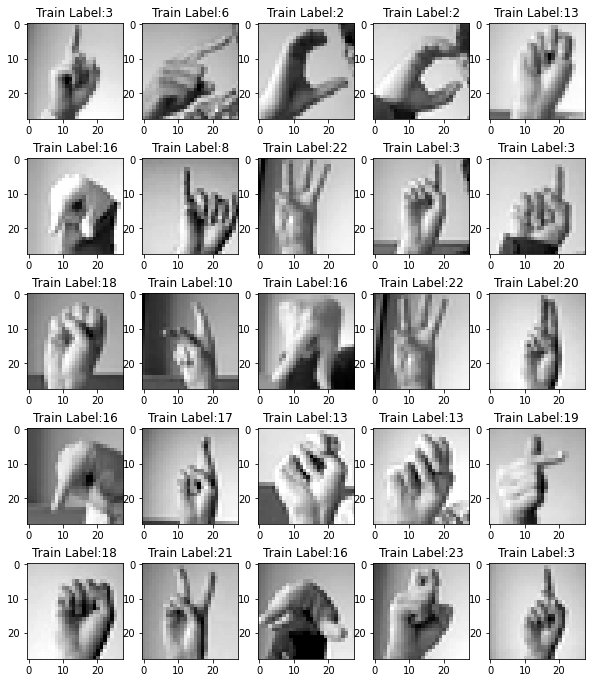

In [8]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(10,12))

for index in range(25):
    
    plt.subplot(5, 5, index+1)
    plt.imshow(train_view[index], cmap='gray')
    plt.title('Train Label:'+str(y_train[index]))
plt.show()

In [9]:
#DATA LOADER
class Signdata(Dataset):
    
    def __init__(self, data, label):
        
        self.data = torch.tensor(data.values.reshape(-1, 1, 28, 28), dtype=torch.float32)
        self.label = torch.tensor(label.values.reshape(-1, 1))
        
    def __len__(self):
        
        return len(self.data)
        
    def __getitem__(self, index):
        
        return self.data[index], self.label[index]


train_x, valid_x, train_y, valid_y = train_test_split(train, y_train, test_size=0.2, stratify=y_train)


traindata = Signdata(train_x, train_y)
validdata = Signdata(valid_x, valid_y)
testdata = Signdata(test, y_test)

traindataloader = DataLoader(traindata, batch_size=128, shuffle=True)
validdataloader = DataLoader(validdata, batch_size=128, shuffle=True)
testdataloader = DataLoader(testdata, shuffle=True)

In [10]:
#data

for index, (data, label) in enumerate(traindataloader):
    
    print(label.shape)
    print(data.dtype)
    print(torch.flatten(label))
    
    if index == 1:
        
        break

torch.Size([128, 1])
torch.float32
tensor([22, 15, 24, 18, 21, 15, 18, 10, 15, 13, 23, 15,  6, 12, 13, 10,  3,  7,
        23, 18, 19, 22, 10, 21,  6, 15,  3, 13, 17, 15, 21, 19,  2, 19, 18, 24,
        18, 16,  2, 11, 13, 13,  2,  0, 14, 14, 19, 23, 18, 24,  0, 24,  1,  5,
         2,  6,  5, 10,  4, 16,  5,  5, 23,  7, 19, 14,  6, 22, 18,  7,  1,  1,
        24,  8, 10, 23, 24,  7,  3, 21, 12, 20, 22, 23, 24, 22,  0,  1, 22, 16,
         7,  5, 17, 23, 14, 14, 18, 18, 14,  8, 15, 12, 22,  4, 13,  5, 21, 15,
        18, 23,  4,  3, 12, 18, 13, 20,  3, 16,  4, 19, 20,  1, 10, 22, 11, 23,
        13, 24])
torch.Size([128, 1])
torch.float32
tensor([ 3, 13, 18, 18,  0, 16, 18,  2,  5, 17, 15, 16,  1, 11, 11, 14,  3,  1,
        23, 24,  0,  0, 23, 15, 16,  1, 13,  6,  4, 21,  8, 20, 14, 17,  2, 11,
        14,  0, 13, 16,  5, 21, 14, 16,  6,  0, 18,  3, 11, 24, 18,  3, 17,  3,
         1, 20,  2, 21, 19, 13, 18, 24,  4,  3, 19,  5,  3, 18, 19,  7,  6,  8,
        13,  5,  3, 22, 14,  4, 1

In [11]:
# MODEL
class Modelinit(nn.Module):
    
    def __init__(self, ch=1, outs=25):
        
        super().__init__()
        self.ch = ch
        self.outs = outs
        
        self.seq1 = nn.Sequential(
                    nn.BatchNorm2d(self.ch),
                    nn.Conv2d(self.ch, self.ch*6, 3),
                    nn.LeakyReLU() #shape -> (-1, 6, 26, 26)
        )
        
        self.seq2 = nn.Sequential(
                    nn.BatchNorm2d(self.ch*6),
                    nn.Conv2d(self.ch*6, self.ch*12, 3),
                    nn.LeakyReLU(),
                    nn.MaxPool2d(2) #shape -> (-1, 12, 12, 12)
        )
        
        self.seq3 = nn.Sequential(
                    nn.BatchNorm2d(self.ch*12),
                    nn.Conv2d(self.ch*12, self.ch*24, 3),
                    nn.LeakyReLU(),
                    nn.MaxPool2d(2)  #shape -> (-1, 24, 5, 5)
        )
        
        self.f1 = nn.Linear(24*5*5, 254)
        self.b1 = nn.BatchNorm1d(254)
        self.d1 = nn.Dropout(0.5, inplace=True)
        self.f2 = nn.Linear(254, 125)
        self.leakre = nn.LeakyReLU()
        self.f3 = nn.Linear(125, self.outs)
        
    def forward(self, x):
        
        outs = self.seq1(x)
        outs = self.seq2(outs)
        outs = self.seq3(outs)
        
        outs = outs.view(-1, 24*5*5)
        outs = self.d1(self.b1(self.f1(outs)))
        outs = self.f3(self.leakre(self.f2(outs)))
        
        return outs
    

In [12]:
#MODEL TRAIN  AND  TEST

from tqdm.auto import tqdm

class ModelTrain:
    
    
    def __init__(self, train, test, valid, epochs=5):
        
        self.model = Modelinit()
        self.loss = nn.CrossEntropyLoss()
        self.train = train
        self.valid = valid
        self.test = test
        self.epochs = epochs
        self.optim = optim.Adam(self.model.parameters(), lr=0.001)
        
    
    def trainmodel(self):
        
        
        for epoch in range(self.epochs):
            
            self.model.train()
            loop = tqdm(enumerate(self.train),total=len(self.train))
            

            for index, (data, label) in loop:
                outs = self.model(data)
                Loss = self.loss(outs, label.squeeze(dim=1))
                Loss.backward()
                self.optim.step()
                self.optim.zero_grad()


                predicted = nn.Softmax(dim=1)(outs)
                _, predicted = predicted.max(1, keepdim=True) 

                acc_total = (predicted == label).sum()
                samples = label.shape[0]
                running_acc = float(acc_total) / float(samples)

                loop.set_description(f'Train epoch {epoch+1} / {self.epochs}')
                loop.set_postfix(loss=Loss.item(), acc=round(running_acc,3))
                        

            loop_valid = tqdm(enumerate(self.valid),total=len(self.valid))
            with torch.no_grad():
        
                for index, (data, label) in loop_valid:
                
                    self.model.eval()
                    outs = self.model(data)
                    predicted = nn.Softmax(dim=1)(outs)
                    _, predicted = predicted.max(1, keepdim=True) 

                    acc_total = (predicted == label).sum()
                    samples = label.shape[0]
                    running_acc = float(acc_total) / float(samples)

                    loop_valid.set_description(f'Valid epoch {epoch+1} / {self.epochs}')
                    loop_valid.set_postfix(valid_acc=round(running_acc,3))
           
        
    def evaluate(self):
        
            tqdm.write(f"[ Predict Test ] ")
        

            labels = torch.LongTensor()
            pred = torch.LongTensor()
                
            for ind in [0]:

                loop_test = tqdm(enumerate(self.test),total=len(self.test))

                for index, (data, label) in loop_test:

                    with torch.no_grad():
                        self.model.eval()
                        outs = self.model(data)
                        predicted = nn.Softmax(dim=1)(outs)
                        _, predicted = predicted.max(1, keepdim=True) 

                        labels = torch.cat((labels, label), dim=0)
                        pred = torch.cat((pred, predicted), dim=0)

                        acc_total = (predicted == label).sum()
                        samples = label.shape[0]
                        running_acc = float(acc_total) / float(samples)

                        loop_test.set_description('Predict-Test')
                        loop_test.set_postfix(Test_acc=round(running_acc,3))


            tqdm.write(classification_report(labels.numpy(), pred.numpy()))

    
    def run(self):
        
        self.trainmodel()
        
        self.evaluate()
        

In [13]:
model = ModelTrain(traindataloader, testdataloader, validdataloader)
model.run()

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

[ Predict Test ] 


  0%|          | 0/7172 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       331
           1       1.00      1.00      1.00       432
           2       1.00      1.00      1.00       310
           3       0.93      0.91      0.92       245
           4       0.98      0.98      0.98       498
           5       0.93      1.00      0.96       247
           6       0.81      0.88      0.84       348
           7       1.00      0.89      0.94       436
           8       0.94      0.93      0.94       288
          10       0.94      0.92      0.93       331
          11       0.92      1.00      0.96       209
          12       0.97      0.91      0.94       394
          13       0.97      0.84      0.90       291
          14       1.00      1.00      1.00       246
          15       0.99      1.00      0.99       347
          16       0.90      1.00      0.95       164
          17       0.98      0.85      0.91       144
          18       0.85    